In [4]:
import os
import time
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
import json, pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch.nn as nn, torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize
import psutil
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
try:
    save_root = '/content/drive/MyDrive'
except Exception:
    save_root = './checkpoints'

os.makedirs(save_root, exist_ok=True)

In [3]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [5]:

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Train‐time augmentation + normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Test‐time normalization only
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

#any generic transform you want to re-use
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_set = CIFAR10(root='./data',
                    train=True,
                    download=True,
                    transform=transform_train)
train_loader = DataLoader(train_set,batch_size=128,shuffle=True,num_workers=2)

# Subset of the *first* 1000 examples
# 10 000 total
full_test_set   = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
#  first 1 000 test images
test_subset_1k  = Subset(full_test_set, indices=list(range(1000)))
test_loader_1k  = DataLoader(test_subset_1k, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 39.0MB/s]


In [6]:
# Model, loss, optimizer

# Load ImageNet‐pretrained backbone
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [7]:
#  Training loop

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=10,
                                            gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()   # decay LR every 10 epochs

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {running_loss/len(train_loader):.4f}")

# OLD
# epochs = 10
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     t0 = time.time()
#     for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#         X, y = X.to(device), y.to(device)
#         optimizer.zero_grad()
#         out = model(X)
#         loss = criterion(out, y)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * X.size(0)
#     print(f"Epoch {epoch+1} Loss: {running_loss/len(train_ds):.4f}  Time: {time.time()-t0:.1f}s")


Epoch 1/10, Loss: 1.0502
Epoch 2/10, Loss: 0.7248
Epoch 3/10, Loss: 0.6315
Epoch 4/10, Loss: 0.5778
Epoch 5/10, Loss: 0.5258
Epoch 6/10, Loss: 0.5017
Epoch 7/10, Loss: 0.4702
Epoch 8/10, Loss: 0.4545
Epoch 9/10, Loss: 0.4380
Epoch 10/10, Loss: 0.4172


In [10]:
# Save full checkpoint directory

checkpoint_dir = os.path.join(save_root, "checkpoint-resnet18")
os.makedirs(checkpoint_dir, exist_ok=True)

#  model weights
torch.save(model.state_dict(),
           os.path.join(checkpoint_dir, "pytorch_model.bin"))

#  config.json
config = {
    "architecture": "resnet18",
    "num_classes":  10,
    "pretrained":   True,
    "epochs":       num_epochs,
    "batch_size":   train_loader.batch_size,
    "lr":           optimizer.param_groups[0]["lr"],
}
with open(os.path.join(checkpoint_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

#  training_args.bin
training_args = {
    "epochs":      num_epochs,
    "batch_size":  train_loader.batch_size,
    "lr":           optimizer.param_groups[0]["lr"],
}
with open(os.path.join(checkpoint_dir, "training_args.bin"), "wb") as f:
    pickle.dump(training_args, f)

#  trainer_state.json
trainer_state = {
    "last_epoch": epoch + 1,
    "last_loss":  running_loss / len(train_loader.dataset),
}
with open(os.path.join(checkpoint_dir, "trainer_state.json"), "w") as f:
    json.dump(trainer_state, f, indent=2)

#  optimizer.pt
torch.save(optimizer.state_dict(),
           os.path.join(checkpoint_dir, "optimizer.pt"))

#  rng_state.pth
torch.save(torch.get_rng_state(),
           os.path.join(checkpoint_dir, "rng_state.pth"))

print(f"Full checkpoint saved to {checkpoint_dir}")


Full checkpoint saved to /content/drive/MyDrive/checkpoint-resnet18


In [8]:
# collect preds & trues
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader_1k:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(y.tolist())

y_true, y_pred = all_labels, all_preds


In [9]:
# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%\n")

Test Accuracy: 82.70%



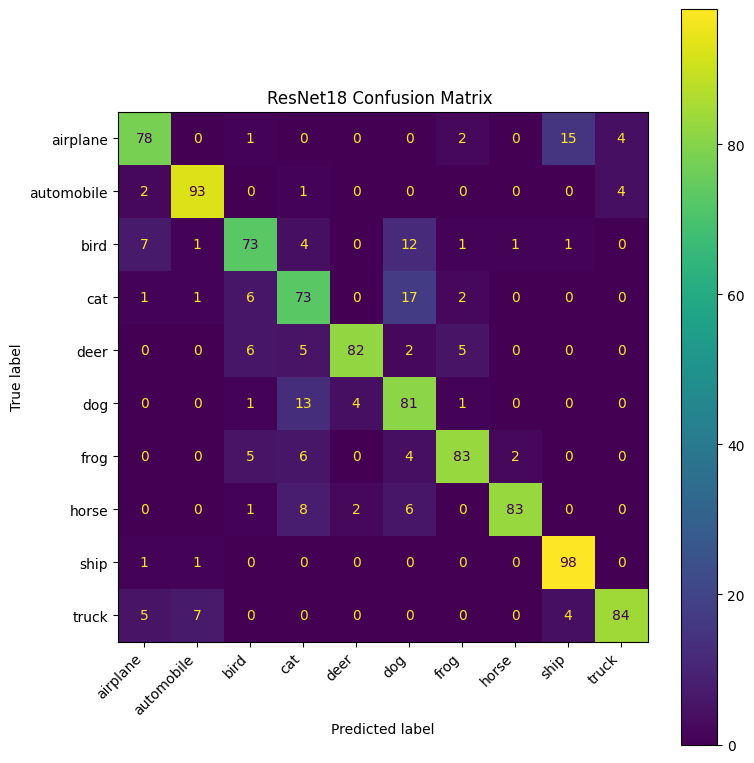

In [13]:
# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


# Build a DataFrame & sample 100 per class
df = pd.DataFrame({"true": y_true, "pred": y_pred})
balanced = pd.concat([
    df[df["true"] == cls]
      .sample(n=100, replace=True, random_state=0)
    for cls in sorted(df["true"].unique())
], ignore_index=True)

y_true_bal = balanced["true"].values
y_pred_bal = balanced["pred"].values

# Compute the confusion matrix on the 100-per-class subset
cm100 = confusion_matrix(y_true_bal, y_pred_bal)

labels = test_subset_1k.dataset.classes
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(
    y_true_bal,
    y_pred_bal,
    display_labels=labels,
    cmap="viridis",
    normalize=None,
    values_format="d",
    ax=ax,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("ResNet18 Confusion Matrix ")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [14]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.8646    0.8058    0.8342       103
           1     0.8842    0.9438    0.9130        89
           2     0.8043    0.7400    0.7708       100
           3     0.6827    0.6893    0.6860       103
           4     0.8427    0.8333    0.8380        90
           5     0.6364    0.8140    0.7143        86
           6     0.8584    0.8661    0.8622       112
           7     0.9286    0.7647    0.8387       102
           8     0.8583    0.9717    0.9115       106
           9     0.9485    0.8440    0.8932       109

    accuracy                         0.8270      1000
   macro avg     0.8309    0.8273    0.8262      1000
weighted avg     0.8343    0.8270    0.8279      1000



In [15]:

param_count = sum(p.numel() for p in model.parameters())
print(f"Parameter count: {param_count:,}")

proc = psutil.Process()
ram_before = proc.memory_info().rss
with torch.no_grad():
    # CIFAR inputs are 32×32, but if you used 224×224 in inference, adjust here:
    _ = model(torch.randn(1, 3, 32, 32).to(device))
ram_after = proc.memory_info().rss
print(f"RAM  (single inference): {(ram_after-ram_before)/1e6:.2f} MB")

Parameter count: 11,181,642
RAM  (single inference): 0.14 MB


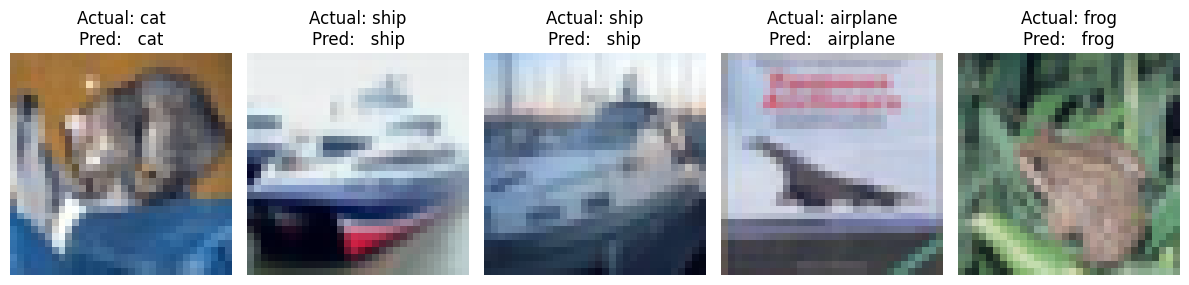

In [16]:

qual_ds = CIFAR10(root='./data', train=False, download=True,
                  transform=Compose([
                      ToTensor(),
                      Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616))
                  ]))
classes = qual_ds.classes

fig, axes = plt.subplots(1,5, figsize=(12,3))
for i, ax in enumerate(axes):
    img, label = qual_ds[i]
    img_input = img.unsqueeze(0).to(device)
    pred = model(img_input).argmax(dim=1).item()

    # approximate un-normalization:
    img = img.permute(1,2,0) * 0.2470 + 0.4914
    ax.imshow(img.clamp(0,1))
    ax.set_title(f"Actual: {classes[label]}\nPred:   {classes[pred]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
##Download the checkpoints as a zip file
from google.colab import files
!zip -r checkpoint-resnet18.zip /content/drive/MyDrive/checkpoint-resnet18
files.download("checkpoint-resnet18.zip")

  adding: content/drive/MyDrive/checkpoint-resnet18/ (stored 0%)
  adding: content/drive/MyDrive/checkpoint-resnet18/trainer_state.json (deflated 12%)
  adding: content/drive/MyDrive/checkpoint-resnet18/rng_state.pth (deflated 40%)
  adding: content/drive/MyDrive/checkpoint-resnet18/training_args.bin (deflated 4%)
  adding: content/drive/MyDrive/checkpoint-resnet18/optimizer.pt (deflated 6%)
  adding: content/drive/MyDrive/checkpoint-resnet18/config.json (deflated 21%)
  adding: content/drive/MyDrive/checkpoint-resnet18/pytorch_model.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>